In [1]:
import pickle
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import deque
%matplotlib inline

## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## 1. Camera Calibration

In [2]:
class CameraCalibrator(object):
    """
    User need to first calibrate the camera
    """
    
    def __init__(self):
        self.mtx = None
        self.dist = None
        
    
    def calibrate(self, chessboard_image_path):
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane
        
        images = glob.glob(os.path.join(chessboard_image_path, '*.jpg'))
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # shape into two columns

        
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # cv2.imread is BGR
            # findChessboardCorners
            ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
            
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
            
        assert len(imgpoints) > 0, 'No corners found!'
        _, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    def undistort(self, image):
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
    
    def save_camera_coeff(self, fname='camera_calibration/camera_coeff'):
        camera_coeff = {} #dist
        camera_coeff['mtx'] = self.mtx
        camera_coeff['dist'] = self.dist
        with open(fname, 'wb') as f:
            pickle.dump(camera_coeff, f)
        print('Camera coefficients (mtx and dist) are saved to {}'.format(fname))
    
    def load_camera_coeff(self, fname='camera_calibration/camera_coeff'):
        with open(fname, 'rb') as f:
            camera_coeff = pickle.load(f)
            self.mtx = camera_coeff['mtx']
            self.dist = camera_coeff['dist']
        print('Camera coefficients (mtx and dist) are loaded from {}'.format(fname))

### Calibrate chessboard images (Important for how to use this class !)

In [3]:
# Only need to run the first time
#camera_calibrator = CameraCalibrator()
#camera_calibrator.calibrate(chessboard_image_path = 'camera_cal/')
#camera_calibrator.save_camera_coeff()

In [4]:
# User need to load the camera coefficient first
camera_calibrator = CameraCalibrator()
camera_calibrator.load_camera_coeff()

Camera coefficients (mtx and dist) are loaded from camera_calibration/camera_coeff


### Visualization example 1

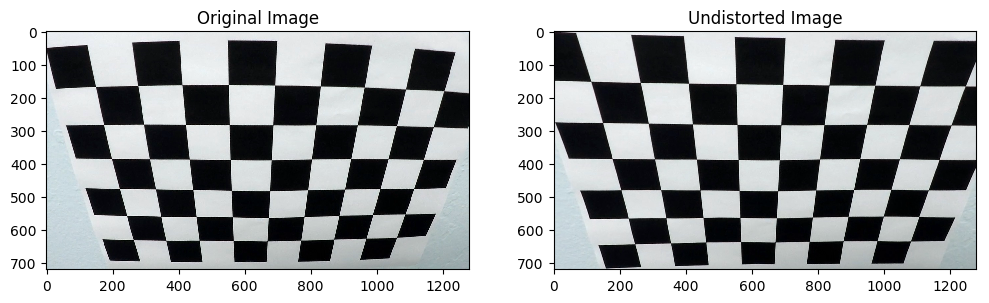

In [5]:
test_image = cv2.imread('camera_cal/calibration2.jpg')
test_undistort = camera_calibrator.undistort(test_image)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(test_undistort)
plt.title('Undistorted Image')

### Visualization example 2

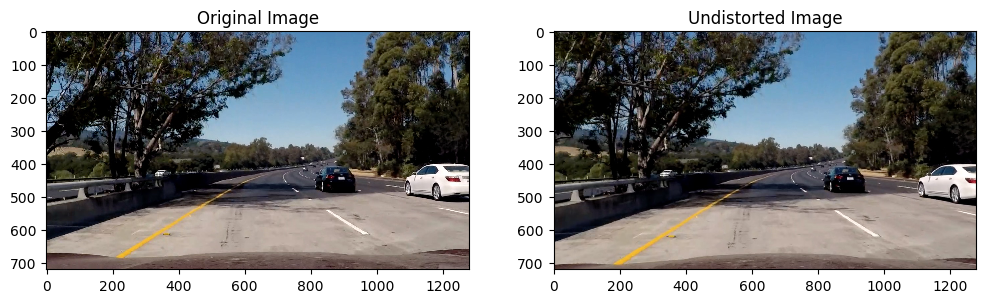

In [6]:
test_image = cv2.imread('test_images/test5.jpg')
test_undistort = camera_calibrator.undistort(test_image)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(test_undistort, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')

## 2. Color Space and Image Filter

The filtering display bad result in HLS color space. Therefore, a good [reference](https://github.com/AlphaLFC/CarND-Advanced-Lane-Lines-P4/blob/master/Advanced-Lane-Lines-P4.ipynb) suggests that can use LAB color space instead.

In [7]:
class ImageFilter:
    """
    ImageFilter converts the image into different Color space (HLS or LAB) and operates Sobel on it.
    """
    def __init__(self):
        self.S_thresh = [170, 255] # saturation filter
        self.L_thresh = 170
        self.B_thresh = 60
        self.sobel_thresh = [20, 100]
        self.m_thresh = [30, 255]  # [magnitude_threshold_low, magnitude_threshold_high]
        self.g_thresh = [0.7, 1.3] # [gradient_threshold_low, gradient_threshold_high]
        
    def _BGR2HLS(self, image):
        """
        Convert the image to HLS color space
        """
        HLS = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        return HLS
    
    def _BGR2LAB(self, image):
        """
        Convert the image to LAB color space
        """
        LAB = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        return LAB 
        
    def _sobel_absolute_with_gaussian_blur(self, gray_image, sobel_thresh ,kernel_size=3):
        """
        Apply sobel in both x and y direction. In addition, using gaussian smoothing
        """
        sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=kernel_size)
        sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=kernel_size)
        sobel_x_abs = np.absolute(sobel_x)
        sobel_y_abs = np.absolute(sobel_y)
        sobel_x_scaled = np.uint8(255 * sobel_x_abs/np.max(sobel_x_abs))
        sobel_y_scaled = np.uint8(255 * sobel_y_abs/np.max(sobel_y_abs))
        # Gaussian smoothing
        sobel_x_scaled = cv2.GaussianBlur(sobel_x_scaled, (kernel_size,)*2, kernel_size) #???
        sobel_y_scaled = cv2.GaussianBlur(sobel_y_scaled, (kernel_size,)*2, kernel_size)
        
        binary = np.zeros_like(gray_image)
        binary[ (sobel_x_scaled > sobel_thresh[0]) & (sobel_x_scaled < sobel_thresh[1]) & \
                (sobel_y_scaled > sobel_thresh[0]) & (sobel_y_scaled < sobel_thresh[1])] = 1
        return binary        
    
    def _sobel_magnitude(self, gray_image, m_thresh, kernel_size=3):
        """
        return a binary 
        """
        sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=kernel_size)
        sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=kernel_size)
        sobel_magnitude = np.sqrt((sobel_x)**2 + (sobel_y)**2)
        scaled_sobel = np.uint8(255 * sobel_magnitude/np.max(sobel_magnitude)) # re-sacle to [0, 255]
        binary_out = np.zeros_like(gray_image)
        binary_out[(scaled_sobel > m_thresh[0]) & (scaled_sobel < m_thresh[1])] = 1
        return binary_out
        
    def _sobel_gradient(self, gray_image, g_thresh, kernel_size=3):
        """
        return a binary
        """
        sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=kernel_size)
        sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=kernel_size)
        sobel_x_abs = np.absolute(sobel_x)
        sobel_y_abs = np.absolute(sobel_y)
        
        grad_direction = np.arctan2(sobel_y_abs, sobel_x_abs) # direction of graident
        binary_out = np.zeros_like(gray_image)
        binary_out[(grad_direction >= g_thresh[0]) & (grad_direction <= g_thresh[1])] = 1
        return binary_out
         
    def _sobel_filter(self, gray_image, m_thresh, g_thresh):
        """
        Apply sobel filter
        return a binary
        """
        m_binary = self._sobel_magnitude(gray_image, m_thresh)
        #g_bianry = self._sobel_gradient(gray_image, g_thresh)
        
        #combined_binary = np.zeros_like(gray_image)
        #combined_binary[(m_binary == 1) & (g_bianry == 1)] = 1
        
        return m_binary
    
    def _saturation_filter(self, image, S_thresh):
        """
        return a binary
        """
        # 1. BGR -> HLS
        HLS = self._BGR2HLS(image)
        S = HLS[:,:,2]
        
        binary = np.zeros_like(S)
        binary[(S > S_thresh[0]) & (S < S_thresh[1])] = 1
        
        return binary
        
    def _lab_filter(self, LAB_image, L_thresh, B_thresh):
        """
        Apply threshold on LAB color space and median filtering
        """
        L = LAB_image[:,:,0]
        B = LAB_image[:,:,2]
        
        #Median filtering
        median_L = np.int(np.median(L))
        median_B = np.int(np.median(B))
        
        L[L < median_L] = median_L
        B[B < median_B] = median_B
        
        # L channel thresh for white color extraction
        # B channel thresh for yellow color extraction
        L_scaled = (L - np.min(L)) * 255.0 / (np.max(L) - np.min(L))
        B_scaled = (B - np.min(B)) * 255.0 / (np.max(B) - np.min(B))
        binary = np.zeros_like(L)
        binary[L_scaled > L_thresh] = 1
        binary[B_scaled > B_thresh] = 1
        
        return binary
        
    def apply(self, image):
        """
        Currently only apply _lab_filter and _sobel_absolute_with_gaussian_blur
        """
        
        # 1. _lab_filter
        LAB = self._BGR2LAB(image)
        binary_lab = self._lab_filter(LAB, self.L_thresh, self.B_thresh)
        
        # 2. Sobel filter
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sobel_binary = self._sobel_absolute_with_gaussian_blur(gray, self.sobel_thresh)
        
        combined_binary = np.zeros_like(gray)
        combined_binary[(binary_lab == 1) | (sobel_binary == 1)] = 1  # OR!
        
        return combined_binary

### Visualization of image filter

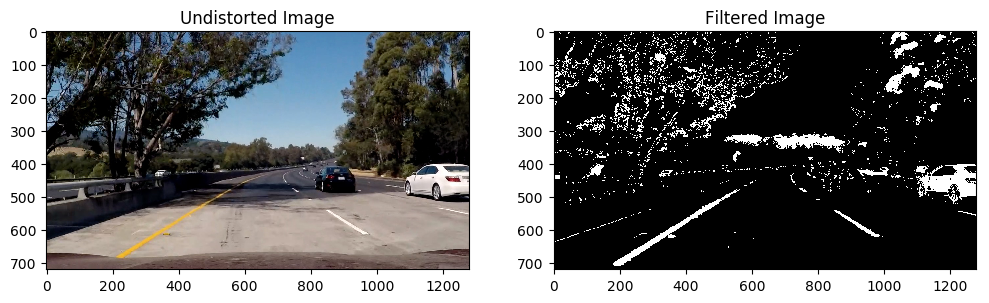

In [8]:
image_filter = ImageFilter()
binary = image_filter.apply(test_undistort)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')
plt.subplot(1,2,2)
plt.imshow(binary, cmap='gray')
plt.title('Filtered Image')


## 3. Perspective Transform

In [9]:
class PerspectiveTransform:
    """
    Image perspective transform
    """
    def __init__(self, src=np.float32([[572, 450], [0, 720], [1280, 720],[702, 450]]), \
                       dst=np.float32([[160, 0], [160, 720], [1120, 720], [1000, 0]])):
        self.src = src
        self.dst = dst
    
    def get_transform_matrix(self):
        matrix = cv2.getPerspectiveTransform(self.src, self.dst)
        return matrix
    
    def get_inv_transform_matrix(self):
        matrix = cv2.getPerspectiveTransform(self.dst, self.src)
        return matrix
    
    def transform(self, image, M):
        height, width = image.shape[0], image.shape[1]
        warped_image = cv2.warpPerspective(image, M, (width, height))
        
        return warped_image

### visualization

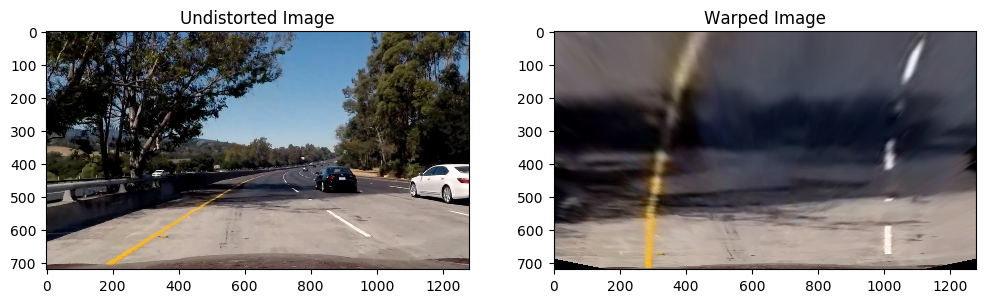

In [10]:
perspectiveTransform = PerspectiveTransform()
M = perspectiveTransform.get_transform_matrix()
test_warped_image = perspectiveTransform.transform(test_undistort, M)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(test_undistort, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(test_warped_image, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')


## 4. Fitting Lane Lines

## Trial

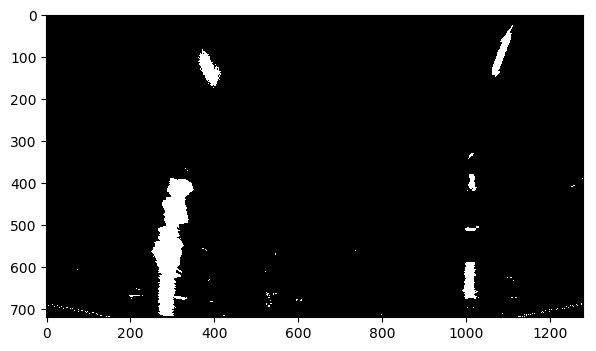

In [11]:
test_binary = image_filter.apply(test_warped_image)
plt.figure(figsize=(12,4), dpi=100)
plt.imshow(test_binary, cmap='gray')

In [12]:
histogram = np.sum(test_binary[test_binary.shape[0]//2:,:], axis =0)
out_img = np.dstack((test_binary, test_binary, test_binary)) * 255
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [13]:
nwindows = 9
window_height = np.int(test_binary.shape[0]/nwindows)
nonzero = test_binary.nonzero()
nonzeroy = np.array(nonzero[0]) # This return the "normal coordinate system"
nonzerox = np.array(nonzero[1])

In [14]:
# current position (will be updated at each window)
leftx_current = leftx_base
rightx_current = rightx_base

margin = 100
minpix = 40

#empy list for left/right lane pixel indices
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    win_y_low = test_binary.shape[0] - (window+1)* window_height
    win_y_high = test_binary.shape[0] - (window)*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin 
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the rectangle 
    cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2) # left lane
    cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2) # right lane
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]  

    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append the indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If the found indcies > minpix, recenter next window to the mean position !
    if len(good_left_inds) > minpix: 
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)  
right_fit = np.polyfit(righty, rightx, 2)        


### Visualization

(720, 0)

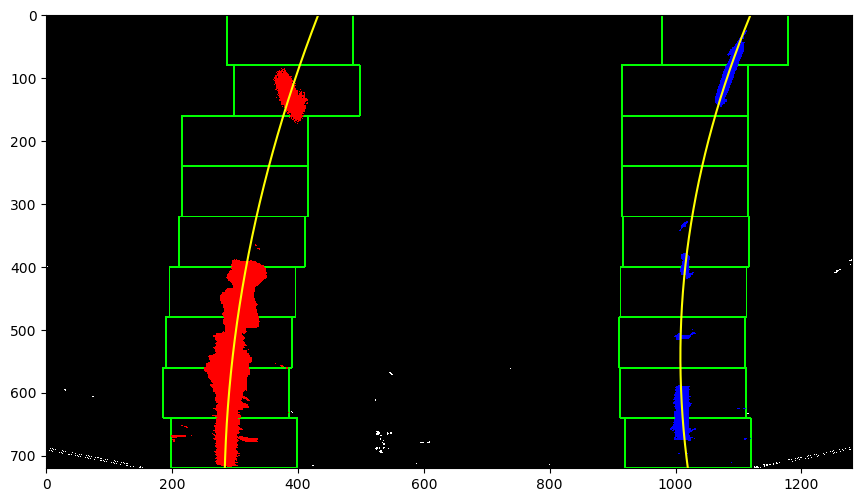

In [15]:
# Generate x and y values for plotting
ploty = np.linspace(0, test_binary.shape[0]-1, test_binary.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(16,6), dpi=100)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

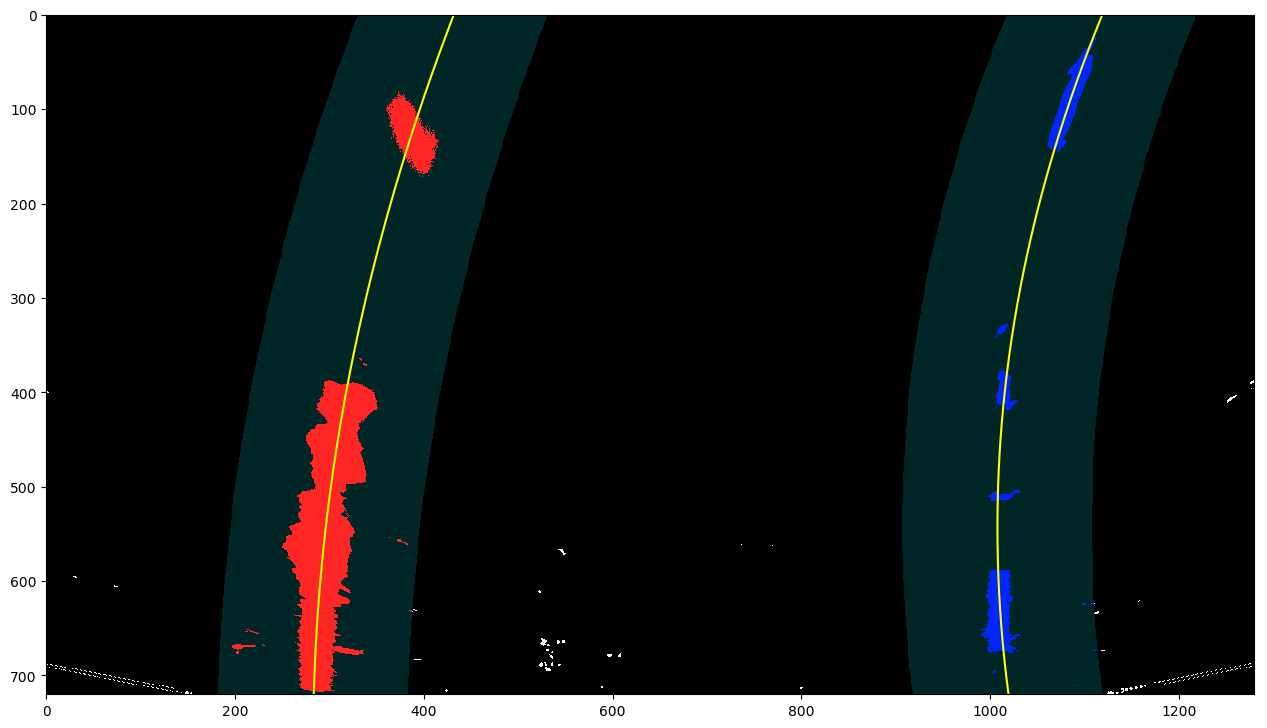

In [16]:
# Faster search base on the previous infomation of the "polynomial fit"
polyfit_l = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2]
left_lane_inds = ((nonzerox > polyfit_l - margin) & (nonzerox < polyfit_l + margin))

polyfit_r = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
right_lane_inds = ((nonzerox > polyfit_r - margin) & (nonzerox < polyfit_r + margin))

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polunomial
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, test_binary.shape[0]-1, test_binary.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((test_binary, test_binary, test_binary))*255
window_img = np.zeros_like(out_img)
# Color in Left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the serach windows area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane ontot eh warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,125,125))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,125,125))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(16,9), dpi=100)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0,1280)
plt.ylim(720,0)

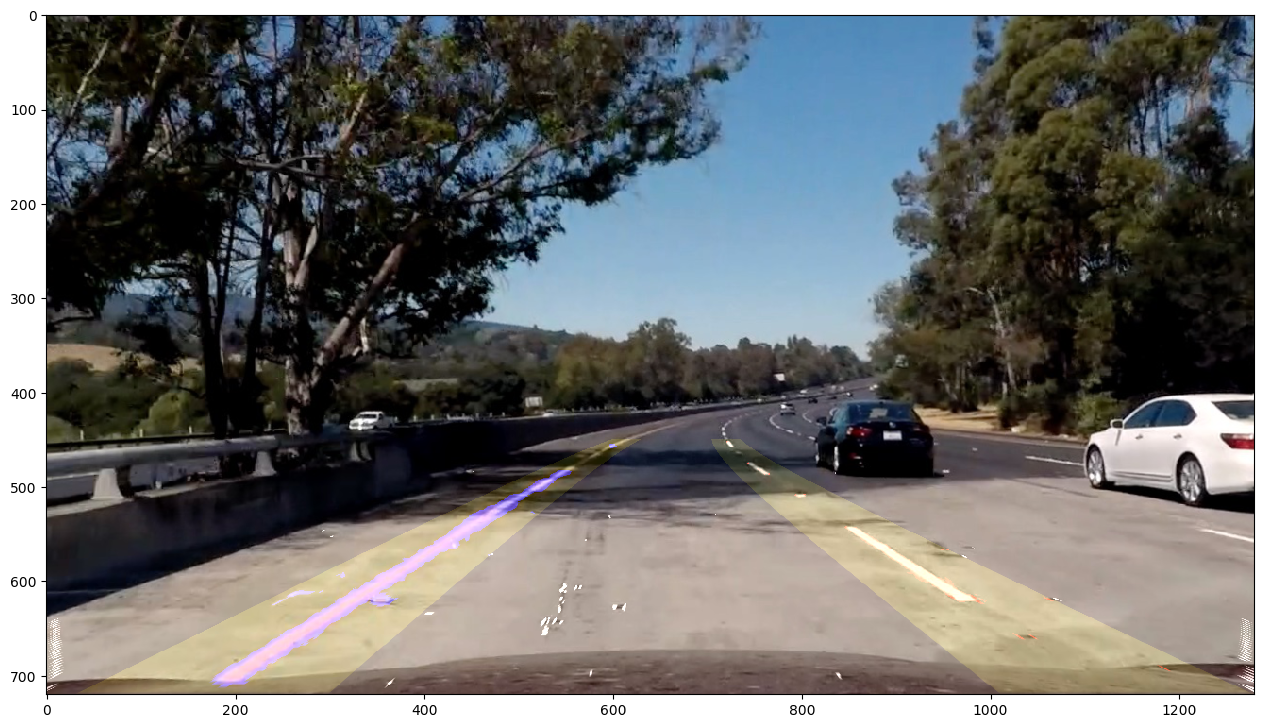

In [17]:
# Back into the original image
M_inv = perspectiveTransform.get_inv_transform_matrix()
inv_img = perspectiveTransform.transform(result, M_inv)
inv_result = cv2.addWeighted(test_undistort, 1, inv_img, 0.7, 0)
plt.figure(figsize=(16,9),dpi=100)
plt.imshow(cv2.cvtColor(inv_result, cv2.COLOR_BGR2RGB))

## Into a class

In [102]:
class LaneLineFinder(object):
    
    def __init__(self, img_size=(1280,720), margin=85, lane_color=(0,255,0), left_line_color=(255, 0, 0), \
                 right_line_color=(0, 0, 255), xm_per_pix=3.8/700, ym_per_pix=32/720):
        self.img_size = img_size
        self.margin = margin
        self.lane_color = lane_color
        self.left_line_color = left_line_color
        self.right_line_color = right_line_color
        self.margin_points = {'l':[], 'r':[]} # dict to store the line points of left/right line
        # meters per pixel in x,y dimension, based on 2 meter
        self.xm_per_pix = xm_per_pix
        self.ym_per_pix = ym_per_pix
        
    def polyfit(self, xl, yl, xr, yr):
        fit_l = np.polyfit(yl, xl, 2)
        fit_r = np.polyfit(yr, xr, 2)
        return fit_l, fit_r
        
    def visualize_line_poitns(self, xl, yl, xr, yr, draw_margin=False):
        """
        Visualize the line points
        left line: red
        right line: blue
        
        Optional to draw the margin of line
        """
        shape_x, shape_y = self.img_size # 1280, 720 by default
        line_img = np.zeros((shape_y, shape_x, 3)).astype(np.uint8) #image coorditinate (720, 1280, 3)
        line_img[yl, xl] = list(self.left_line_color)
        line_img[yr, xr] = list(self.right_line_color)
        
        if(draw_margin):
            margin_points_l = self.margin_points['l']
            margin_points_r = self.margin_points['r']
            if(len(margin_points_l) | len(margin_points_r)):
                mcolor_l = np.array(self.left_line_color) + 127 # margin color is slightly diffent than the line color
                mcolor_r = np.array(self.right_line_color) + 127
                mcolor_l[mcolor_l > 255] = 255 # Limit the pixel to 255
                mcolor_r[mcolor_r > 255] = 255
                mcolor_l = tuple(mcolor_l.tolist())
                mcolor_r = tuple(mcolor_r.tolist())
                # Draw
                cv2.polylines(line_img, np.int_([margin_points_l]), True, mcolor_l, 2)
                cv2.polylines(line_img, np.int_([margin_points_r]), True, mcolor_r, 2)
            else:
                print('No margin points from both left and right')
                
        return line_img
            
        
    def visualize_lane_area(self, fit_l, fit_r):
        
        shape_x, shape_y = self.img_size # 1280, 720
        lane_img = np.zeros((shape_y, shape_x, 3)).astype(np.uint8) #image coorditinate (720, 1280, 3)
        y_points = np.linspace(0, shape_y-1, shape_y)
        fit_l_x = fit_l[0] * (y_points)**2 + fit_l[1] * y_points + fit_l[2]
        fit_r_x = fit_r[0] * (y_points)**2 + fit_r[1] * y_points + fit_r[2]
        fit_l_points = list(zip(fit_l_x, y_points)) # zip into a coordinate (x, y)
        fit_r_points = list(zip(fit_r_x, y_points))
        fit_r_points.reverse() # revsere the right side to concatenate for cv2.fillPoly
        fit_points = fit_l_points + fit_r_points # concatenate
        
        cv2.fillPoly(lane_img, np.int_([fit_points]), self.lane_color)
        return lane_img
    
    def find_line_blind_search(self, img_binary_warped, nwindows=9, minpix=50, collect_margin_points=False):
        '''
        Blindly search of line from a binary wraped image
        return found line in pixel indices
        '''
        shape_y, shape_x = img_binary_warped.shape[:2] # skip depth
        assert(shape_x, shape_y) == self.img_size, 'Need 720 x 1280 iamges'
        
        # Histogram of nonzero pixels from 360 -> 720 for the buttom part of the image
        hist = np.sum(img_binary_warped[img_binary_warped.shape[0]//2:,:], axis=0)
        
        # Set the base of line position
        midpoint = np.int(shape_x / 2) # 640 as midpoint
        margin = self.margin
        xl_base = np.argmax(hist[:midpoint])
        xr_base = np.argmax(hist[midpoint:]) + midpoint
        win_height = np.int(shape_y / nwindows)
        
        # current left/right x coordinate, need to be updated while the searching
        xl_current = xl_base
        xr_current = xr_base 
        
        lane_idxs_l = []
        lane_idxs_r = []
        
        nonzero = img_binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0]) # 720
        nonzerox = np.array(nonzero[1]) # 1280
        
        if collect_margin_points:
            margin_points_l_l = []
            margin_points_l_r = []
            margin_points_r_l = []
            margin_points_r_r = []
            
        for window in range(nwindows):
            # Identify window boundaries in x and y (and left/right)
            y_up = shape_y - (window+1)* win_height
            y_down = shape_y - window * win_height
            xl_l = xl_current - margin
            xl_r = xl_current + margin
            xr_l = xr_current - margin
            xr_r = xr_current + margin
            
            # Append margin points
            if collect_margin_points:
                margin_points_l_l.append((xl_l, y_down))
                margin_points_l_l.append((xl_l, y_up))
                margin_points_l_r.append((xl_r, y_down))
                margin_points_l_r.append((xl_r, y_up))

                margin_points_r_l.append((xr_l, y_down))
                margin_points_r_l.append((xr_l, y_up))
                margin_points_r_r.append((xr_r, y_down))
                margin_points_r_r.append((xr_r, y_up))

            # Identify the nonzero pixels in x and y within the window
            # Note that the nonzeroy is in "image coordinate"
            good_idxs_l = ((nonzeroy >= y_up) & (nonzeroy < y_down) & \
                           (nonzerox >= xl_l) & (nonzerox < xl_r)).nonzero()[0] 
            
            good_idxs_r = ((nonzeroy >= y_up) & (nonzeroy < y_down) & \
                           (nonzerox >= xr_l) & (nonzerox < xr_r)).nonzero()[0]
            
            # Append these indices to the lists
            lane_idxs_l.append(good_idxs_l)
            lane_idxs_r.append(good_idxs_r)
            
            #If found > minpix pixels, recenter next window on their mean position
            if len(good_idxs_l) > minpix:
                xl_current = np.int(np.mean(nonzerox[good_idxs_l]))
            if len(good_idxs_r) > minpix:
                xr_current = np.int(np.mean(nonzerox[good_idxs_r]))
                
        if collect_margin_points:
                margin_points_l_r.reverse()
                margin_points_r_r.reverse()
                self.margin_points['l'] = margin_points_l_l + margin_points_l_r
                self.margin_points['r'] = margin_points_r_l + margin_points_r_r
                
        # Concatenate
        lane_idxs_l = np.concatenate(lane_idxs_l)
        lane_idxs_r = np.concatenate(lane_idxs_r)

        xl = nonzerox[lane_idxs_l]
        yl = nonzeroy[lane_idxs_l]
        xr = nonzerox[lane_idxs_r]
        yr = nonzeroy[lane_idxs_r]

        return xl, yl, xr, yr
                
    def find_line_fit_margin(self, img_binary_warped, fit_l, fit_r, collect_margin_points=False):
        
        shape_y, shape_x = img_binary_warped.shape[:2]
        assert(shape_x, shape_y) == self.img_size, 'Need 720 x 1280 iamges!'

        margin = self.margin
        
        if collect_margin_points:
            y_points = np.linspace(0, shape_y-1, shape_y)
            fit_l_x = fit_l[0] * (y_points)**2 + fit_l[1] * y_points + fit_l[2]
            fit_r_x = fit_r[0] * (y_points)**2 + fit_r[1] * y_points + fit_r[2]
            
            margin_points_l_l = list(zip(fit_l_x - margin, y_points))
            margin_points_l_r = list(zip(fit_l_x + margin, y_points))
            margin_points_l_r.reverse()
            
            margin_points_r_l = list(zip(fit_r_x - margin, y_points))
            margin_points_r_r = list(zip(fit_r_x + margin, y_points))
            margin_points_r_r.reverse()
            
            self.margin_points['l'] = margin_points_l_l + margin_points_l_r
            self.margin_points['r'] = margin_points_r_l + margin_points_r_r
            
        nonzero = img_binary_warped.nonzero()
        nonzeroy = nonzero[0]
        nonzerox = nonzero[1]
        
        fit_l_x_pts = fit_l[0] * nonzeroy **2 + fit_l[1] * nonzeroy + fit_l[2]
        fit_r_x_pts = fit_r[0] * nonzeroy **2 + fit_r[1] * nonzeroy + fit_r[2]
        
        lane_idxs_l = ((nonzerox > (fit_l_x_pts - margin)) & (nonzerox < (fit_l_x_pts + margin)))
        lane_idxs_r = ((nonzerox > (fit_r_x_pts - margin)) & (nonzerox < (fit_r_x_pts + margin)))
        
        xl = nonzerox[lane_idxs_l]
        yl = nonzeroy[lane_idxs_l] 
        xr = nonzerox[lane_idxs_r]
        yr = nonzeroy[lane_idxs_r]
        
        return xl, yl, xr, yr
    
    def get_lane_geometry(self, fit_l, fit_r):
        '''
        Return the radius of both left/right, and departure of center of lane.
        '''
        
        shape_y = self.img_size[1]
        y_points = np.linspace(0, shape_y-1, shape_y)
        fit_l_x = fit_l[0] * (y_points)**2 + fit_l[1] * y_points + fit_l[2]
        fit_r_x = fit_r[0] * (y_points)**2 + fit_r[1] * y_points + fit_r[2]
        
        # Center of the road 
        center_pixel = np.mean(fit_l_x[-1] + fit_r_x[-1]) # last point
        print('center pixel: {}'.format(center_pixel))
        center = (center_pixel - self.img_size[0]/2) * self.xm_per_pix  # convert to world length
        
        # Fit x,y in real world space
        ym_points = y_points * self.ym_per_pix
        fit_l_m = np.polyfit(ym_points, fit_l_x * self.xm_per_pix, 2)
        fit_r_m = np.polyfit(ym_points, fit_r_x * self.xm_per_pix, 2)
        
        y_max = np.max(ym_points) # bottom part of the image
        radius_l = ((1 + (2 * fit_l_m[0] * y_max + fit_l_m[1])**2)**1.5) / np.absolute(2*fit_l_m[0])
        radius_r = ((1 + (2 * fit_r_m[0] * y_max + fit_r_m[1])**2)**1.5) / np.absolute(2*fit_r_m[0])
        
        return (radius_l, radius_r), center
        
        
        
        
            

### Visaulization

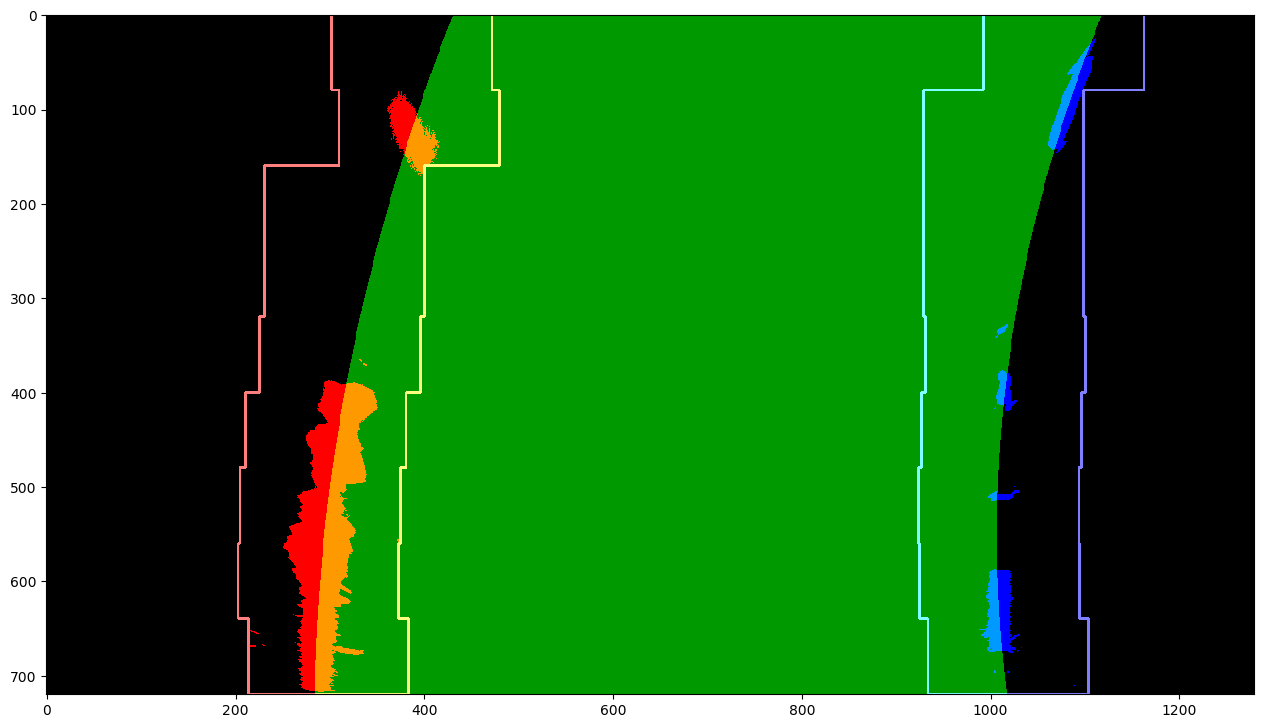

In [103]:
laneLineFit=LaneLineFinder()
line_points = laneLineFit.find_line_blind_search(test_binary, collect_margin_points=True)
fits = laneLineFit.polyfit(*line_points)

line_img = laneLineFit.visualize_line_poitns(*line_points, draw_margin=True)
lane_img = laneLineFit.visualize_lane_area(*fits)
img_fit_warped = cv2.addWeighted(line_img, 1, lane_img, 0.6, 0)
plt.figure(figsize=(16,9),dpi=100)
plt.imshow(img_fit_warped)

### Visaulization

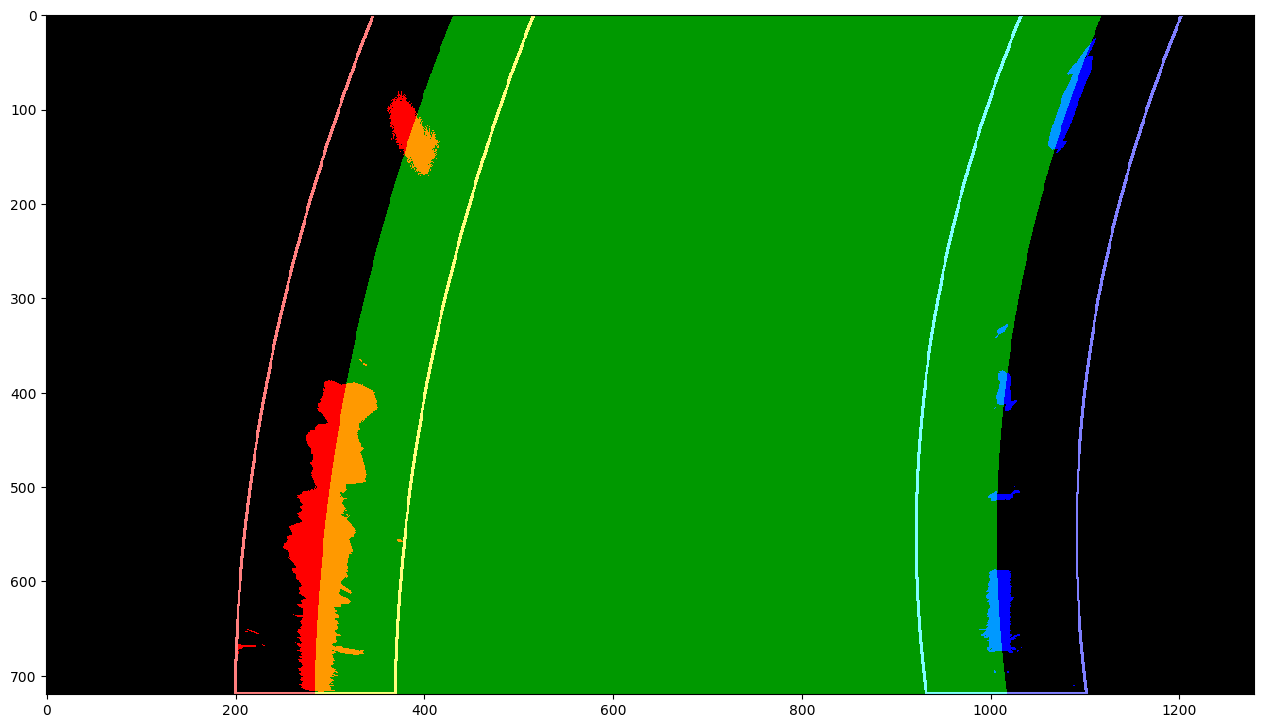

In [104]:
line_points = laneLineFit.find_line_fit_margin(test_binary, *fits, collect_margin_points=True)
line_img = laneLineFit.visualize_line_poitns(*line_points, draw_margin=True)
lane_img = laneLineFit.visualize_lane_area(*fits)
img_fit_warped = cv2.addWeighted(line_img, 1, lane_img, 0.6, 0)
plt.figure(figsize=(16,9),dpi=100)
plt.imshow(img_fit_warped)

### Visaulization

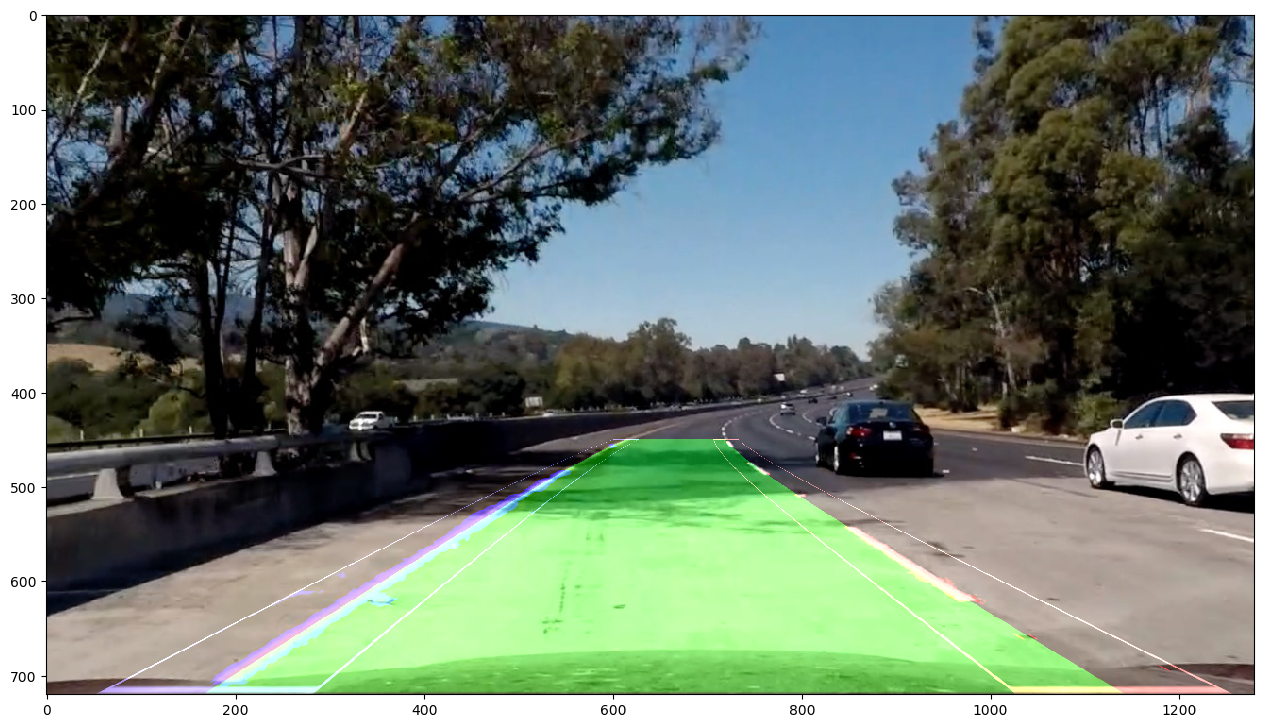

In [105]:
# Back into the original image
M_inv = perspectiveTransform.get_inv_transform_matrix()
inv_img = perspectiveTransform.transform(img_fit_warped, M_inv)
inv_result = cv2.addWeighted(test_undistort, 1, inv_img, 0.7, 0)
plt.figure(figsize=(16,9),dpi=100)
plt.imshow(cv2.cvtColor(inv_result, cv2.COLOR_BGR2RGB))

## PipeLine for lane finding in image

In [110]:
class ImageLaneDetector(object):
    """
    Host class of previous policy class
    """
    def __init__(self, camera_calibrator, image_filter, image_transformer, lane_line_finder):
        self.camera_calibrator = camera_calibrator
        self.image_filter = image_filter
        self.image_transformer = image_transformer
        self.lane_line_finder = lane_line_finder
        
        self.radius_of_curve = None
        self.center_departure = None
        
    def pre_process(self, image):
        
        """
        Out put the binary warped image for the convenience usage before LaneLineFinder
        """
        
        # Undistort the original image
        undistorted_img = self.camera_calibrator.undistort(image)
        # Image filter in LAB color space and Sobel operation
        binary_img = image_filter.apply(undistorted_img)
        # User need to explicitly get the transformation matrix
        M = image_transformer.get_transform_matrix()
        # Apply transformation into a warped image
        binary_warp_img = image_transformer.transform(binary_img, M)
        
        return binary_warp_img
        
        
    def apply(self, image):
        
        binary_warp_img = self.pre_process(image)
        line_points = self.lane_line_finder.find_line_blind_search(binary_warp_img)
        fits = self.lane_line_finder.polyfit(*line_points)
        lane_img = self.lane_line_finder.visualize_lane_area(*fits)
        line_img = self.lane_line_finder.visualize_line_poitns(*line_points)
        
        lane_line_warp_img = cv2.addWeighted(line_img, 1, lane_img, 0.6, 0)
        
        # User need to explicitly get the inverse transofrmation matrix
        M_inv = self.image_transformer.get_inv_transform_matrix()
        lane_line = self.image_transformer.transform(lane_line_warp_img, M_inv)
        
        # Undistort the original image
        undistorted_img = self.camera_calibrator.undistort(image)
        out_img = cv2.addWeighted(undistorted_img, 0.8, lane_line, 0.7, 0)
        
        # lane geometry
        lane_geometry = self.lane_line_finder.get_lane_geometry(*fits)
        self.radius_of_curve = np.mean(lane_geometry[0]) # average between left & right curve
        self.center_departure = lane_geometry[1]
        
        if self.radius_of_curve <= 1500:
            message_radius = 'Radius: {:.1f} m'.format(self.radius_of_curve)
        else:
            message_radius = 'Current ego lane is nearly stright'
        
        if self.center_departure == 0:
            message_center = 'Ego vehicle is at the center'
        elif self.center_departure > 0:
            message_center = 'Center departure: {:.2f} m [Left]'.format(self.center_departure)
        else:
            message_center = 'Center departure: {:.2f} m [Right]'.format(self.center_departure)
        
        cv2.putText(out_img, message_radius, (200, 100), 0, 1.2, (255, 255, 0), 2)
        cv2.putText(out_img, message_center, (200, 150), 0, 1.2, (255, 255, 0), 2)
        
        return out_img
        

### visaulization

In [111]:
# Init
camera_calibrator = CameraCalibrator()
# User need to either "calibrate" or "load the camera coefficent" fist
camera_calibrator.load_camera_coeff()

image_filter = ImageFilter()
image_transformer = PerspectiveTransform()
lane_line_finder = LaneLineFinder()
# Init for Image Detector
image_detector = ImageLaneDetector(camera_calibrator, image_filter, image_transformer, lane_line_finder)

Camera coefficients (mtx and dist) are loaded from camera_calibration/camera_coeff


In [112]:
img_test = cv2.imread('test_images/test4.jpg')
result = image_detector.apply(img_test)

center pixel: 1414.3235420334288


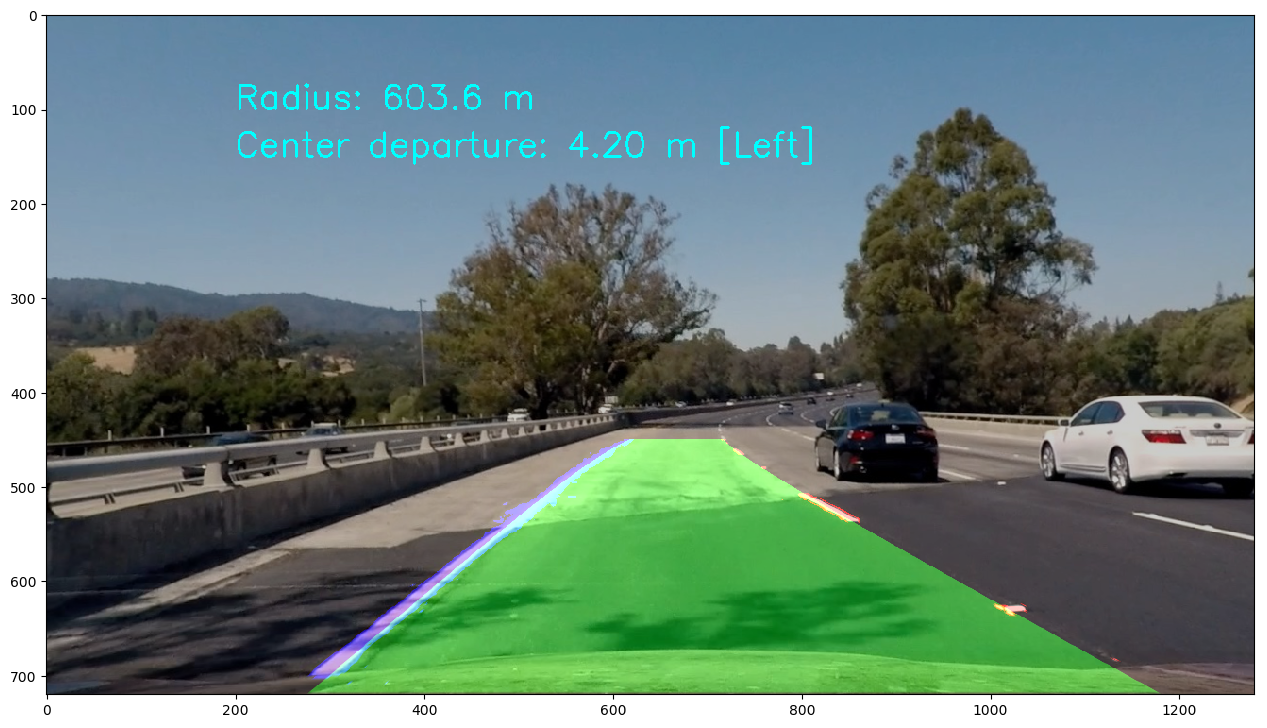

In [113]:
plt.figure(figsize=(18,9), dpi=100)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## PipeLine for lane finding in Video


In [85]:
from moviepy.editor import VideoFileClip

input_video = VideoFileClip('challenge_video.mp4')
processed_video = input_video.fl_image(image_detector.apply)

output_video = 'challenge_video_output.mp4'
%time processed_video.write_videofile(output_video, audio=False)

OSError: [WinError 6] The handle is invalid